In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set_style('whitegrid')

## Data Loading and Preprocessing

In [3]:
# Load historical price data
historical_data = pd.read_csv("../data/processed/binance/merged_historical_data.csv")
historical_data['date'] = pd.to_datetime(historical_data['timestamp'])
historical_data.set_index('date', inplace=True)

# Load funding rate data
funding_data = pd.read_csv("../data/processed/binance/merged_funding_data.csv")
funding_data['date'] = pd.to_datetime(funding_data['timestamp'])

# Load volume and liquidity data
volume_liquidity_data = pd.read_csv("../data/processed/binance/merged_trading_volume_liquidity_data.csv")
volume_liquidity_data['date'] = pd.to_datetime(volume_liquidity_data['timestamp'])

# Display data summary
print(f"Historical data period: {historical_data.index.min()} to {historical_data.index.max()}")
print(f"Number of pairs in historical data: {historical_data['pair'].nunique()}")
print(f"Number of funding rate records: {len(funding_data)}")
print(f"Number of pairs with funding rates: {funding_data['pair'].nunique()}")

Historical data period: 2023-05-11 00:00:00 to 2025-05-10 00:00:00
Number of pairs in historical data: 8
Number of funding rate records: 15414
Number of pairs with funding rates: 8


In [4]:
historical_data.head()

,timestamp,open,high,low,close,volume,daily_return,volatility,log_return,pair
date,,,,,,,,,,
2023-05-11,2023-05-11,0.051756,0.036446,0.042333,0.038686,0.031083,-0.022705,0.033101,-0.022967,BTC_USDC
2023-05-12,2023-05-12,0.038691,0.025180,0.023110,0.034933,0.087623,-0.006674,0.047050,-0.006696,BTC_USDC
2023-05-13,2023-05-13,0.035016,0.024352,0.041925,0.034460,0.012799,-0.000987,0.013180,-0.000987,BTC_USDC
2023-05-14,2023-05-14,0.034677,0.027605,0.039650,0.037570,0.012862,0.005191,0.022963,0.005178,BTC_USDC
2023-05-15,2023-05-15,0.037552,0.037280,0.042927,0.042413,0.036922,0.008673,0.034395,0.008635,BTC_USDC


In [22]:
# Get the max date for SOL_USDC pair
sol_usdc_max_date = historical_data[historical_data['pair'] == 'SOL_USDC'].index.min()
print(f'Latest date for SOL_USDC: {sol_usdc_max_date}')


Latest date for SOL_USDC: 2023-12-28 00:00:00


## LP and Hedging Simulation Functions

In [7]:
def calculate_impermanent_loss(
    initial_price: float, 
    current_price: float
) -> float:
    """
    Calculate the impermanent loss for a 50-50 LP position
    
    Args:
        initial_price: The price when LP position was created
        current_price: The current price
        
    Returns:
        Impermanent loss as a percentage (negative value)
    """
    price_ratio = current_price / initial_price
    il = 2 * np.sqrt(price_ratio) / (1 + price_ratio) - 1
    return il  # This will be negative for any price change

def calculate_lp_fees(
    volume: float,
    fee_rate: float,
    lp_share: float,
    position_size: float,
    total_liquidity: float
) -> float:
    """
    Calculate fees earned by LP position
    
    Args:
        volume: Trading volume for the period
        fee_rate: LP fee rate (e.g., 0.003 for 0.3%)
        lp_share: Share of fees going to LPs (e.g., 0.7 for 70%)
        position_size: Size of LP position in USD
        total_liquidity: Total liquidity in the pool in USD
        
    Returns:
        Fees earned as a percentage of position size
    """
    if total_liquidity == 0:
        return 0
    
    # Calculate LP position's share of the pool
    pool_share = position_size / total_liquidity
    
    # Calculate fees earned
    total_fees = volume * fee_rate * lp_share
    position_fees = total_fees * pool_share
    
    # Return as percentage of position size
    return position_fees / position_size

def calculate_perp_pnl(
    entry_price: float,
    exit_price: float,
    is_short: bool = True,
    leverage: float = 1.0
) -> float:
    """
    Calculate P&L for a perpetual futures position
    
    Args:
        entry_price: Entry price for the perp position
        exit_price: Exit/current price for the perp position
        is_short: True if short position, False if long
        leverage: Leverage used (e.g., 3 for 3x)
        
    Returns:
        P&L as a percentage of position size
    """
    if is_short:
        pnl_pct = (entry_price - exit_price) / entry_price
    else:
        pnl_pct = (exit_price - entry_price) / entry_price
        
    return pnl_pct * leverage

def calculate_funding_cost(
    funding_rates: List[float],
    is_short: bool = True,
    leverage: float = 1.0
) -> float:
    """
    Calculate cumulative funding cost/income for a perp position
    
    Args:
        funding_rates: List of funding rates for each period
        is_short: True if short position, False if long
        leverage: Leverage used
        
    Returns:
        Cumulative funding cost/income as a percentage (negative for cost)
    """
    # For short positions, positive funding rate is a cost (negative return)
    # For long positions, positive funding rate is income (positive return)
    sign = -1 if is_short else 1
    
    # Sum the funding rates and multiply by leverage
    total_funding = sum(funding_rates) * sign * leverage
    
    return total_funding

def simulate_lp_with_hedge(
    pair: str,
    historical_df: pd.DataFrame,
    funding_df: pd.DataFrame,
    volume_df: pd.DataFrame,
    start_date: str,
    duration_hours: int,
    hedge_ratio: float = 0.5,
    leverage: float = 1.0,
    fee_rate: float = 0.003,
    lp_share: float = 0.7,
    position_size_usd: float = 10000
) -> Dict:
    """
    Simulate an LP position with a perp hedge over a specific time period
    
    Args:
        pair: Trading pair (e.g., "SOL_USDC")
        historical_df: DataFrame with historical price data
        funding_df: DataFrame with funding rate data
        volume_df: DataFrame with volume and liquidity data
        start_date: Start date for the simulation (YYYY-MM-DD)
        duration_hours: Duration of simulation in hours
        hedge_ratio: Ratio of the LP position to hedge (0.0 to 1.0)
        leverage: Leverage for the hedge position
        fee_rate: Trading fee rate for the LP
        lp_share: Share of fees going to LPs
        position_size_usd: Size of LP position in USD
        
    Returns:
        Dict with simulation results
    """
    # Convert start_date to datetime
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.Timedelta(hours=duration_hours)
    
    # Filter data for the simulation period
    hist_period = historical_df[
        (historical_df.index >= start_date) & 
        (historical_df.index <= end_date) &
        (historical_df['pair'] == pair)
    ]
    
    funding_period = funding_df[
        (funding_df['date'] >= start_date) & 
        (funding_df['date'] <= end_date) &
        (funding_df['pair'] == pair)
    ]
    
    volume_period = volume_df[
        (volume_df['date'] >= start_date) & 
        (volume_df['date'] <= end_date) &
        (volume_df['pair'] == pair)
    ]
    
    if len(hist_period) == 0:
        return {"error": f"No historical data found for {pair} in the specified period"}
    
    # Get initial and final prices
    initial_price = hist_period.iloc[0]['close']
    final_price = hist_period.iloc[-1]['close']
    
    # Calculate impermanent loss
    il = calculate_impermanent_loss(initial_price, final_price)
    
    # Calculate LP fees earned
    # Use average daily volume and liquidity
    avg_daily_volume = volume_period['volume'].mean() if len(volume_period) > 0 else 0
    avg_liquidity = volume_period['liquidity'].mean() if len(volume_period) > 0 else 0
    
    # Scale to the duration
    duration_days = duration_hours / 24
    total_volume = avg_daily_volume * duration_days
    
    fees_earned = calculate_lp_fees(
        total_volume,
        fee_rate,
        lp_share,
        position_size_usd,
        avg_liquidity
    )
    
    # Calculate perp hedge P&L
    hedge_pnl = 0
    if hedge_ratio > 0:
        hedge_pnl = calculate_perp_pnl(
            initial_price,
            final_price,
            is_short=True,  # Assuming short hedge against LP
            leverage=leverage
        ) * hedge_ratio
    
    # Calculate funding costs/income
    funding_rates = funding_period['funding_rate'].tolist() if len(funding_period) > 0 else [0]
    funding_impact = calculate_funding_cost(
        funding_rates,
        is_short=True,  # Assuming short hedge
        leverage=leverage
    ) * hedge_ratio
    
    # Calculate net P&L
    net_pnl = fees_earned + il + hedge_pnl + funding_impact
    
    # Prepare results
    results = {
        "pair": pair,
        "start_date": start_date,
        "end_date": end_date,
        "duration_hours": duration_hours,
        "hedge_ratio": hedge_ratio,
        "leverage": leverage,
        "initial_price": initial_price,
        "final_price": final_price,
        "price_change_pct": (final_price - initial_price) / initial_price * 100,
        "impermanent_loss": il * 100,  # Convert to percentage
        "lp_fees_earned": fees_earned * 100,  # Convert to percentage
        "hedge_pnl": hedge_pnl * 100,  # Convert to percentage
        "funding_impact": funding_impact * 100,  # Convert to percentage
        "net_pnl": net_pnl * 100,  # Convert to percentage
    }
    
    return results

## Simulation Runner and Time-Based Analysis

In [16]:
def run_time_based_simulations(
    pair: str,
    historical_df: pd.DataFrame,
    funding_df: pd.DataFrame,
    volume_df: pd.DataFrame,
    start_date: str,
    durations: List[int],  # in hours
    hedge_ratios: List[float],
    leverages: List[float]
) -> pd.DataFrame:
    """
    Run multiple simulations for different time periods, hedge ratios, and leverages
    
    Args:
        pair: Trading pair to simulate
        historical_df: Historical price data
        funding_df: Funding rate data
        volume_df: Volume and liquidity data
        start_date: Start date for simulations
        durations: List of durations to simulate (in hours)
        hedge_ratios: List of hedge ratios to test
        leverages: List of leverage values to test
        
    Returns:
        DataFrame with simulation results
    """
    results = []
    
    for duration in durations:
        for hedge_ratio in hedge_ratios:
            for leverage in leverages:
                sim_result = simulate_lp_with_hedge(
                    pair=pair,
                    historical_df=historical_df,
                    funding_df=funding_df,
                    volume_df=volume_df,
                    start_date=start_date,
                    duration_hours=duration,
                    hedge_ratio=hedge_ratio,
                    leverage=leverage
                )
                
                if "error" not in sim_result:
                    results.append(sim_result)
    
    return pd.DataFrame(results)

def visualize_simulation_results(results_df: pd.DataFrame, metric: str = 'net_pnl'):
    """
    Visualize simulation results
    
    Args:
        results_df: DataFrame with simulation results
        metric: Metric to visualize (default: net_pnl)
    """
    # Create a pivot table for easy visualization
    pivot = results_df.pivot_table(
        index=['duration_hours', 'hedge_ratio'],
        columns='leverage',
        values=metric
    )
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title(f'{metric} (%) by Duration, Hedge Ratio, and Leverage')
    plt.ylabel('Duration (hours), Hedge Ratio')
    plt.xlabel('Leverage')
    plt.tight_layout()
    plt.show()
    
    # Plot line chart for time-based performance
    plt.figure(figsize=(12, 6))
    for leverage in results_df['leverage'].unique():
        for hedge_ratio in results_df['hedge_ratio'].unique():
            subset = results_df[
                (results_df['leverage'] == leverage) & 
                (results_df['hedge_ratio'] == hedge_ratio)
            ].sort_values('duration_hours')
            
            plt.plot(
                subset['duration_hours'], 
                subset[metric], 
                marker='o',
                label=f'Leverage: {leverage}x, Hedge: {hedge_ratio*100}%'
            )
    
    plt.title(f'Time-Based {metric} (%) Performance')
    plt.xlabel('Duration (hours)')
    plt.ylabel(f'{metric} (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Pair-Specific Simulations

In [17]:
# Define simulation parameters
start_date = '2023-05-11'  # Use a date with available data
durations = [6, 12, 24, 48, 72]  # hours
hedge_ratios = [0.0, 0.5, 0.75, 1.0]  # 0%, 50%, 75%, 100%
leverages = [1.0, 3.0, 5.0]  # 1x, 3x, 5x

# Pairs to simulate
pairs = [
    'BTC_USDC',  # SOL-USDC
    # Note: We'll need to add/map data for these pairs if available:
    # 'FARTCOIN_SOL',  # Fartcoin-SOL
    # 'JLP_SOL'        # JLP-SOL
]

# Run simulations for SOL-USDC
sol_usdc_results = run_time_based_simulations(
    pair='BTC_USDC',
    historical_df=historical_data,
    funding_df=funding_data,
    volume_df=volume_liquidity_data,
    start_date=start_date,
    durations=durations,
    hedge_ratios=hedge_ratios,
    leverages=leverages
)

In [18]:
print(sol_usdc_results)

        pair start_date            end_date  duration_hours  hedge_ratio  \
0   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.00   
1   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.00   
2   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.00   
3   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.50   
4   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.50   
5   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.50   
6   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.75   
7   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.75   
8   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         0.75   
9   BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         1.00   
10  BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         1.00   
11  BTC_USDC 2023-05-11 2023-05-11 06:00:00               6         1.00   
12  BTC_USDC

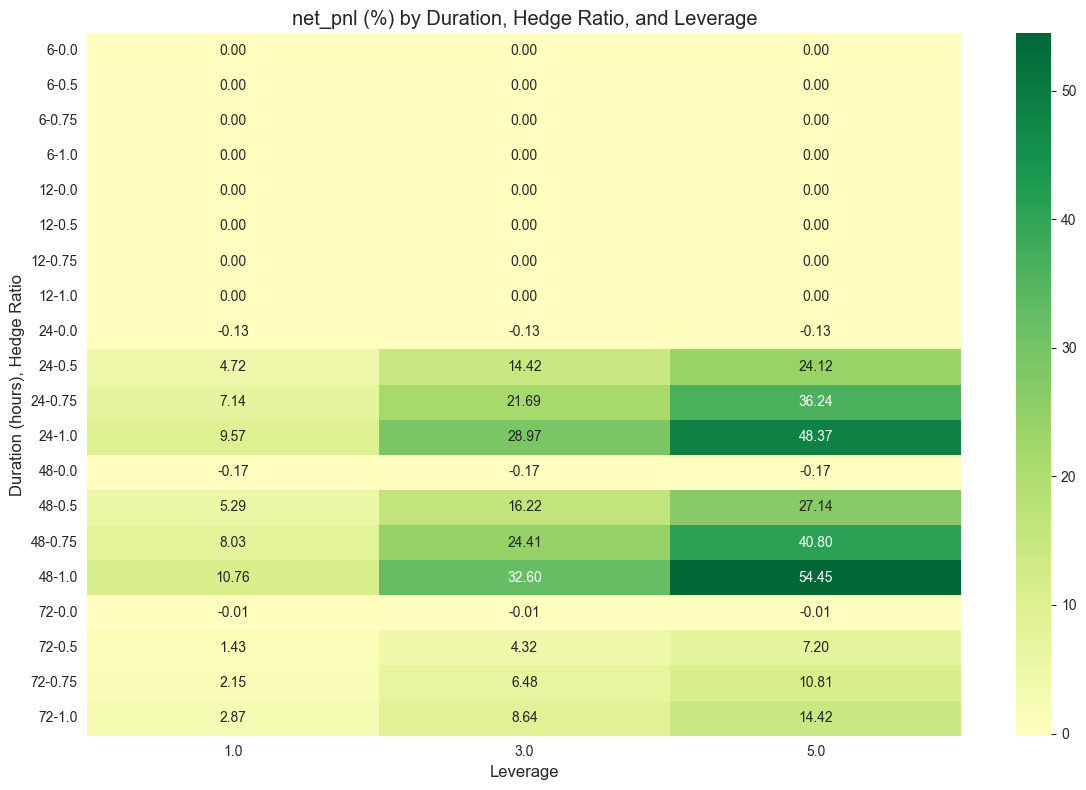

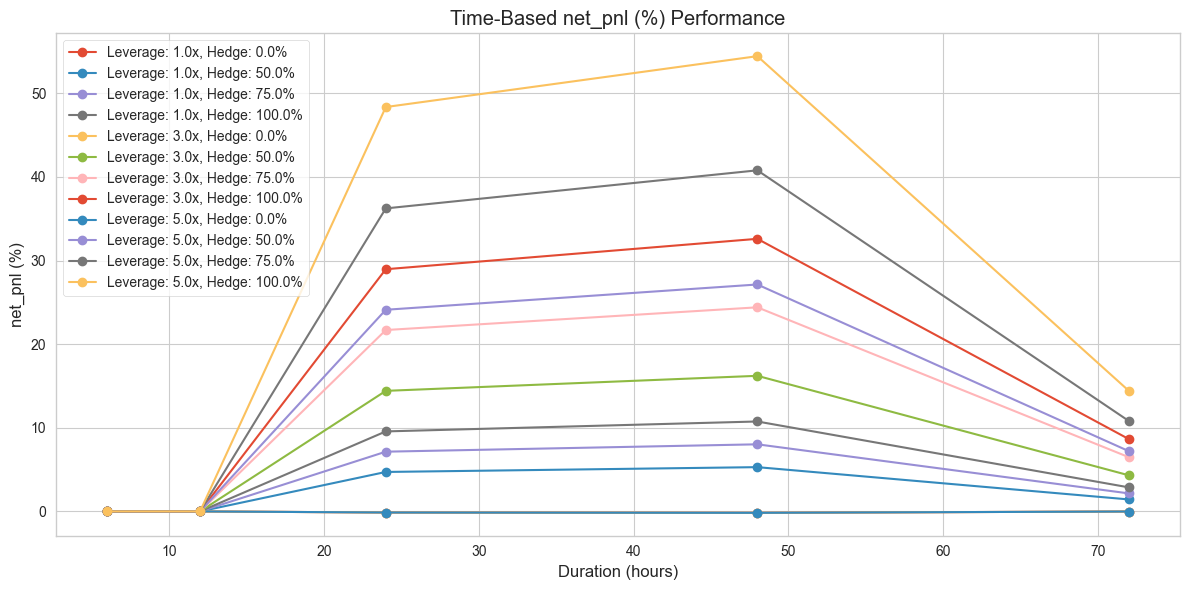

In [19]:
sol_usdc_results[['duration_hours', 'hedge_ratio', 'leverage', 
                 'impermanent_loss', 'lp_fees_earned', 
                 'hedge_pnl', 'funding_impact', 'net_pnl']]

# Visualize results
visualize_simulation_results(sol_usdc_results, 'net_pnl')

## Strategy Comparison and Recommendations


Best Strategy for SOL-USDC:
Hedge Ratio: 100.0%
Leverage: 5.0x
Average Return: 23.45%
Risk-Adjusted Return: 0.89
Strategy Score: 9.65


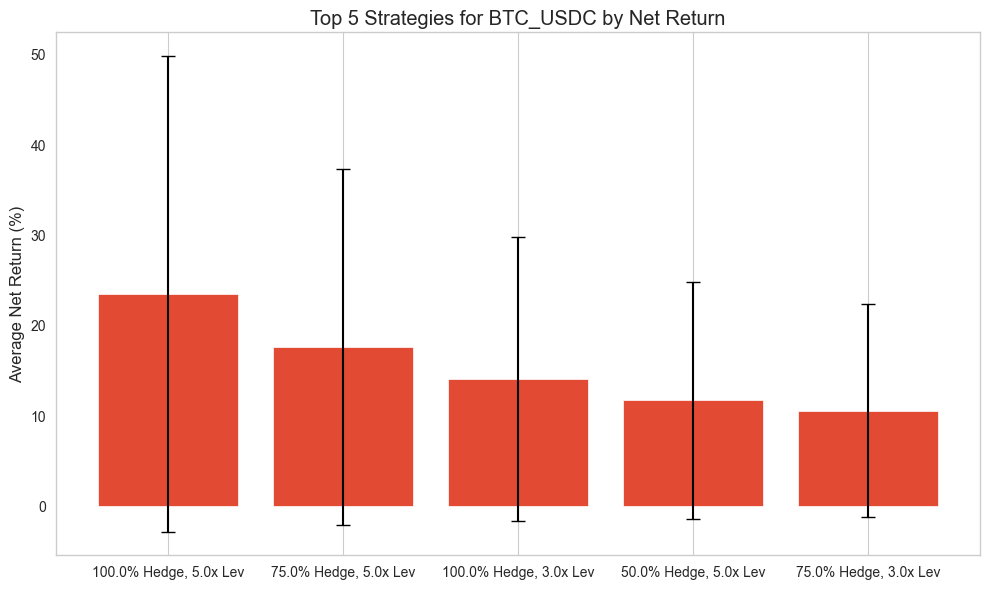

In [21]:
def compare_strategies(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compare different strategies and provide recommendations
    
    Args:
        results_df: DataFrame with simulation results
        
    Returns:
        DataFrame with strategy recommendations
    """
    # Group by hedge ratio and leverage to find best performing strategies
    strategy_comparison = results_df.groupby(['hedge_ratio', 'leverage']).agg({
        'net_pnl': ['mean', 'std', 'min', 'max'],
        'impermanent_loss': 'mean',
        'lp_fees_earned': 'mean',
        'hedge_pnl': 'mean',
        'funding_impact': 'mean'
    }).reset_index()
    
    # Flatten multi-level columns
    strategy_comparison.columns = ['_'.join(col).strip('_') for col in strategy_comparison.columns.values]
    
    # Calculate risk-adjusted return (Sharpe-like ratio)
    strategy_comparison['risk_adjusted_return'] = strategy_comparison['net_pnl_mean'] / strategy_comparison['net_pnl_std']
    
    # Calculate strategy score (higher is better)
    strategy_comparison['strategy_score'] = (
        strategy_comparison['net_pnl_mean'] * 0.4 +  # Weight mean return at 40%
        strategy_comparison['risk_adjusted_return'] * 0.3 +  # Weight risk-adjusted return at 30%
        strategy_comparison['net_pnl_min'] * 0.3  # Weight worst-case scenario at 30%
    )
    
    # Sort by strategy score
    return strategy_comparison.sort_values('strategy_score', ascending=False)

# Compare strategies for SOL-USDC
sol_usdc_strategy_comparison = compare_strategies(sol_usdc_results)

# Display strategy comparison
sol_usdc_strategy_comparison[['hedge_ratio', 'leverage', 
                            'net_pnl_mean', 'net_pnl_std', 
                            'risk_adjusted_return', 'strategy_score']]

# Identify the best strategies
best_strategy = sol_usdc_strategy_comparison.iloc[0]
print(f"\nBest Strategy for SOL-USDC:")
print(f"Hedge Ratio: {best_strategy['hedge_ratio']*100}%")
print(f"Leverage: {best_strategy['leverage']}x")
print(f"Average Return: {best_strategy['net_pnl_mean']:.2f}%")
print(f"Risk-Adjusted Return: {best_strategy['risk_adjusted_return']:.2f}")
print(f"Strategy Score: {best_strategy['strategy_score']:.2f}")

# Plot top strategies comparison
top_strategies = sol_usdc_strategy_comparison.head(5)
plt.figure(figsize=(10, 6))
plt.bar(
    [f"{r*100}% Hedge, {l}x Lev" for r, l in zip(top_strategies['hedge_ratio'], top_strategies['leverage'])],
    top_strategies['net_pnl_mean'],
    yerr=top_strategies['net_pnl_std'],
    capsize=5
)
plt.title('Top 5 Strategies for BTC_USDC by Net Return')
plt.ylabel('Average Net Return (%)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()